**Imports**

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from memory_profiler import memory_usage
from qiskit.visualization import circuit_drawer



In [3]:
import pennylane as qml
from pennylane import devices

print(qml.__version__)

0.43.1


**Initilize values**

In [4]:
numpy_pi = np.pi
num_qubits = 4
simulator = AerSimulator()
qc = QuantumCircuit(num_qubits, num_qubits) # qubits, classical bits


Gates

In [5]:
#redundant h and cNOT gates on the same qubit(s)
qc.h(0)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 1)

# just a full rotation(2pi) around the x-axis and a (3/2)pi rotation in the z-axis
# completely redundant.
qc.rx((0.5)*numpy_pi,3)

qc.rz((0.5)*numpy_pi,2)
qc.rx((0.5)*numpy_pi,3)
qc.rz(numpy_pi,2)

qc.rx((0.5)*numpy_pi,3)

qc.cx(0,3) # CNOT is non-adjacent

qc.cx(1,2)
qc.rx((0.5)*numpy_pi,3)

qc.measure(range(num_qubits), range(num_qubits))

# Memory usage

In [6]:
def transpile_with_memory(qc, level):
    """
    Returns:
        transpiled_circuit, memory_used_in_MB
    """

    # We need a container to store the transpiled circuit from inside the closure
    result_container = {'circuit': None}

    def run_and_store():
        # Transpile and store the result
        result_container['circuit'] = transpile(qc, optimization_level=level)

    # Measure memory over the duration of run_and_store()
    mem_usage = memory_usage(
        (run_and_store,), 
        interval=0.01, 
        max_iterations=1
    )

    # Calculate memory delta
    mem_used = max(mem_usage) - min(mem_usage)

    # Return BOTH the circuit and its measured memory
    return result_container['circuit'], mem_used

# Circuit outupt(qiskit)

In [11]:

t0, mem0 = transpile_with_memory(qc, 0)
t1, mem1 = transpile_with_memory(qc, 1)
t2, mem2 = transpile_with_memory(qc, 2)
t3, mem3 = transpile_with_memory(qc, 3)



print("Transpiled circuit w optimization 00:", t0.depth())
print("Transpilation memory_usage =",mem0,"MB")
print(t0)

print("Transpiled circuit w optimization 01:", t1.depth())
print("Transpilation memory_usage =",mem1,"MB")
print(t1)


print("Transpiled circuit w optimization 02:", t2.depth())
print("Transpilation memory_usage =",mem2,"MB")
print(t2)


print("Transpiled circuit w optimization 03:", t3.depth())
print("Transpilation memory_usage =",mem3,"MB")
print(t3)


Transpiled circuit w optimization 00: 7
Transpilation memory_usage = 0.015625 MB
        ┌───┐      ┌───┐                                        ┌─┐         
q_0: ───┤ H ├──────┤ H ├────────■───────■─────────■─────────────┤M├─────────
        └───┘      └───┘      ┌─┴─┐   ┌─┴─┐       │             └╥┘┌─┐      
q_1: ─────────────────────────┤ X ├───┤ X ├──■────┼──────────────╫─┤M├──────
     ┌─────────┐ ┌───────┐    └───┘   └───┘┌─┴─┐  │              ║ └╥┘┌─┐   
q_2: ┤ Rz(π/2) ├─┤ Rz(π) ├─────────────────┤ X ├──┼──────────────╫──╫─┤M├───
     ├─────────┤┌┴───────┴┐┌─────────┐     └───┘┌─┴─┐┌─────────┐ ║  ║ └╥┘┌─┐
q_3: ┤ Rx(π/2) ├┤ Rx(π/2) ├┤ Rx(π/2) ├──────────┤ X ├┤ Rx(π/2) ├─╫──╫──╫─┤M├
     └─────────┘└─────────┘└─────────┘          └───┘└─────────┘ ║  ║  ║ └╥┘
c: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                 0  1  2  3 
Transpiled circuit w optimization 01: 4
Transpilation memory_usage = 0.0

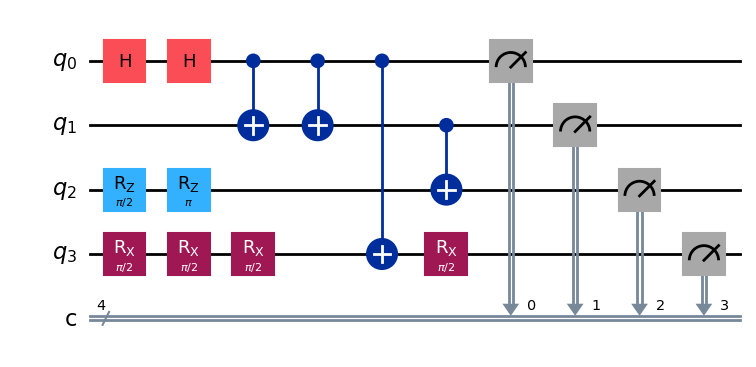

In [14]:
circuit_drawer(qc, output="mpl", plot_barriers=False)


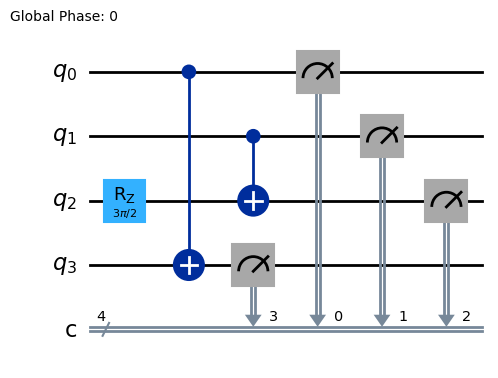

In [15]:
circuit_drawer(t3, output="mpl", plot_barriers=False)

| Optimization Level | Description |
|--------------------|-------------|
| **0** | **No optimization:** typically used for hardware characterization<br><br>• Basic translation<br>• Layout/Routing: `TrivialLayout`, where it selects the same physical qubit numbers as virtual and inserts SWAPs to make it work (using `SabreSwap`) |
| **1** | **Light optimization:**<br><br>• Layout/Routing: First attempts `TrivialLayout`. If additional SWAPs are needed, a layout with the minimum number of SWAPs is searched using `SabreSwap`. Then `VF2LayoutPostLayout` tries to choose better qubits.<br>• `InverseCancellation` (removes pairs of gate inverses)<br>• 1-qubit gate optimization |
| **2** | **Med optimization:**<br><br>• Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater search depth and trials of optimization function. Because TrivialLayout is not used, there is no attempt to use the same physical and virtual qubit numbers.<br>• `CommutativeCancellation` (Removes gates that commute AND cancel, even if they’re not adjacent)|
| **3** | **High optimization:**<br><br>• Optimization level 2, plus heuristic layout/routing optimized with greater search effort/trials<br>• Resynthesis of two-qubit blocks using Cartan's KAK decomposition<br>• Unitarity-breaking passes:<br>&nbsp;&nbsp;&nbsp;&nbsp;• `OptimizeSwapBeforeMeasure`: moves measurements earlier in the circuit to avoid introducing SWAPs<br>&nbsp;&nbsp;&nbsp;&nbsp;• `RemoveDiagonalGatesBeforeMeasure`: removes diagonal gates before measurement since they do not affect measurement results |



# 📘 Analysis of Optimization levels (Qiskit)


- **Optimization Level 0:**  
  Uses only essential transformations; preserves hardware logic with minimal changes.

- **Optimization Level 1:**  

  Cancels Inverse gates (eg. double haddamard and x gates).Recongizes redundant roations like on q_3 where the 4 rotation gates around the x-axis did not change the overall phase. However, only sequential rotation gates. Significantly reduces the circuit depth.
  
  In Qiskit, `TrivialLayout` is a transpiler pass that assigns circuit qubits to device qubits in a straightforward, sequential manner. For example, if a circuit has three qubits (q0, q1, q2), TrivialLayout would map q0 to physical qubit 0, q1 to physical qubit 1, and etc.

- **Optimization Level 2:**  
  Introduces more aggressive optimization passes, including Commutation analysis to reorder gates and `CommutativeCancellation` on q2. More sophisticated routing optimization via SABRE, aiming to minimize SWAP cost.

- **Optimization Level 3:**  
  Optimization level 3 fully resynthesized your single-qubit rotation sequences and applied the most aggressive commutation, cancellation, and routing passes, reducing the circuit to the minimal structure allowed by the hardware. It effectively produced the same optimized layout and gate set as level 2 but confirmed no additional reductions were possible, resulting in a depth-3 circuit with no leftover global phase.



# PennyLane Version

In [73]:
from pennylane.transforms import cancel_inverses, merge_rotations

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit():
    # --- Redundant H and CNOT blocks ---
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=0)   # redundant

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 1])  # redundant
    
    # --- Rotation stack ---
    qml.RX(0.5 * numpy_pi, wires=3)

    qml.RZ(0.5 * numpy_pi, wires=2)
    qml.RX(0.5 * numpy_pi, wires=3)
    qml.RZ(numpy_pi, wires=2)

    qml.RX(0.5 * numpy_pi, wires=3)

    # --- Non-adjacent CNOTs ---
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[1, 2])

    qml.RX(0.5 * numpy_pi, wires=3)

    # Measurement: return probabilities of all qubits
    return qml.probs(wires=range(num_qubits))

# Run circuit
print(qml.draw(circuit)())
optimized_circuit = merge_rotations(cancel_inverses(circuit))
print("\n Optimized Circuit:")
print(qml.draw(optimized_circuit)())

0: ──H─────────H────────╭●────────╭●─╭●───────────┤ ╭Probs
1: ─────────────────────╰X────────╰X─│──╭●────────┤ ├Probs
2: ──RZ(1.57)──RZ(3.14)──────────────│──╰X────────┤ ├Probs
3: ──RX(1.57)──RX(1.57)──RX(1.57)────╰X──RX(1.57)─┤ ╰Probs

 Optimized Circuit:
0: ───────────╭●───────────┤ ╭Probs
1: ───────────│──╭●────────┤ ├Probs
2: ──RZ(4.71)─│──╰X────────┤ ├Probs
3: ──RX(4.71)─╰X──RX(1.57)─┤ ╰Probs


# 📘 Analysis of Optimization levels (Pennylane)

Pennylane did not do communitve cancellations or swaps

# Qiskit Transpilation capabilites. 